# Fake Job Post Detector – NLP-based Fraud Detection System

## Project Overview

__Objective:__ Automatically detect fraudulent job postings using natural language processing (NLP), helping job seekers avoid scams and enhancing platform trustworthiness.

__Dataset:__ Fake Job Postings Dataset - Kaggle

__Skills:__

* Data cleaning & preprocessing
* Text preprocessing for NLP (tokenization, lemmatization)
* Feature extraction (TF-IDF)
* Machine learning (Naive Bayes or Logistic Regression)
* Model evaluation and optimization

#### Overview Dataset

In [30]:
import pandas as pd

df=pd.read_csv('Fake Job Postings Dataset.zip', compression='zip')
df

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0
17876,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0
17877,17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,NaN,0,0,0,Full-time,NaN,NaN,NaN,NaN,0
17878,17879,Graphic Designer,"NG, LA, Lagos",NaN,NaN,NaN,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0


In [31]:
df.nunique()

job_id                 17880
title                  11231
location                3105
department              1337
salary_range             874
company_profile         1709
description            14801
requirements           11967
benefits                6204
telecommuting              2
has_company_logo           2
has_questions              2
employment_type            5
required_experience        7
required_education        13
industry                 131
function                  37
fraudulent                 2
dtype: int64

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15184 non-null  object
 8   benefits             10668 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry             12977 non-null  object
 16  func

In [33]:
df.isnull().sum()

job_id                     0
title                      0
location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2696
benefits                7212
telecommuting              0
has_company_logo           0
has_questions              0
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
fraudulent                 0
dtype: int64

We observe a lot of missing values in the dataset so we need to process it and do data cleaning.

In [34]:
df['fraudulent'].value_counts()

fraudulent
0    17014
1      866
Name: count, dtype: int64

We see the amount of data already detected as fraudulent in a binary 1 or 0, important for the evaluation check of the models predictions.

__Fraudulent Values:__

* 0	: Real job posting 
* 1 : Fake job posting (fraudulent)

#### Handle Missing Values

In [35]:
text_cols=['title', 'company_profile', 'description', 'requirements', 'benefits']
df[text_cols]=df[text_cols].fillna('')

binary_cols = ['telecommuting', 'has_company_logo', 'has_questions']
df[binary_cols]=df[binary_cols].fillna(0)

In [36]:
df['combined_text'] = df['title'] + ' ' + df['description'] + ' ' + df['requirements'] + ' ' + df['company_profile']

#### Text Preprocessing

In [38]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import seaborn as sns
import matplotlib.pyplot as plt

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')


# remove stop words
stop_words= set(stopwords.words('english'))

# lemmatization model
lemmatizer= WordNetLemmatizer()

def preprocess(text):
    text=text.lower()
    text=re.sub(r'[^a-z\s]', '', text)
    tokens=text.split()
    tokens=[lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

df['clean_text']=df['combined_text'].apply(preprocess)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kwnst\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kwnst\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [39]:
df

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,combined_text,clean_text
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,,0,1,0,Other,Internship,NaN,NaN,Marketing,0,"Marketing Intern Food52, a fast-growing, James...",marketing intern food fastgrowing james beard ...
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0,Customer Service - Cloud Video Production Orga...,customer service cloud video production organi...
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,,0,1,0,NaN,NaN,NaN,NaN,NaN,0,Commissioning Machinery Assistant (CMA) Our cl...,commissioning machinery assistant cma client l...
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,Account Executive - Washington DC THE COMPANY:...,account executive washington dc company esri e...
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,Bill Review Manager JOB TITLE: Itemization Rev...,bill review manager job title itemization revi...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17875,17876,Account Director - Distribution,"CA, ON, Toronto",Sales,NaN,Vend is looking for some awesome new talent to...,Just in case this is the first time you’ve vis...,To ace this role you:Will eat comprehensive St...,What can you expect from us?We have an open cu...,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Sales,0,Account Director - Distribution Just in case ...,account director distribution case first time ...
17876,17877,Payroll Accountant,"US, PA, Philadelphia",Accounting,NaN,WebLinc is the e-commerce platform and service...,The Payroll Accountant will focus primarily on...,- B.A. or B.S. in Accounting- Desire to have f...,Health &amp; WellnessMedical planPrescription ...,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Internet,Accounting/Auditing,0,Payroll Accountant The Payroll Accountant will...,payroll accountant payroll accountant focus pr...
17877,17878,Project Cost Control Staff Engineer - Cost Con...,"US, TX, Houston",NaN,NaN,We Provide Full Time Permanent Positions for m...,Experienced Project Cost Control Staff Enginee...,At least 12 years professional experience.Abil...,,0,0,0,Full-time,NaN,NaN,NaN,NaN,0,Project Cost Control Staff Engineer - Cost Con...,project cost control staff engineer cost contr...
17878,17879,Graphic Designer,"NG, LA, Lagos",NaN,NaN,,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0,Graphic Designer Nemsia Studios is looking for...,graphic designer nemsia studio looking experie...


#### Feature Extraction

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

vectorizer =TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_test=vectorizer.fit_transform(df['clean_text'])

# binary features
X=hstack([X_test, df[binary_cols].values])
y= df['fraudulent']

#### Train-Test Split

In [41]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### Model Training

1. Naive Bayes Approach

In [43]:
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# Naive Bayes
nb_model=MultinomialNB()
nb_model.fit(X_train, y_train)
y_pred_nb=nb_model.predict(X_test)

print("Naive Bayes Classification Report")
print(classification_report(y_test, y_pred_nb))

Naive Bayes Classification Report
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      3403
           1       0.66      0.39      0.49       173

    accuracy                           0.96      3576
   macro avg       0.81      0.69      0.74      3576
weighted avg       0.95      0.96      0.96      3576



2. Logistic Regression Approach

In [44]:
# Logistic Regression Model
lr_model=LogisticRegression(max_iter=1000)
lr_model.fit(X_train, y_train)
y_pred_lr=lr_model.predict(X_test)
print("Logistic Regression Classification Report")
print(classification_report(y_test, y_pred_lr))

Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      3403
           1       1.00      0.41      0.58       173

    accuracy                           0.97      3576
   macro avg       0.99      0.71      0.78      3576
weighted avg       0.97      0.97      0.97      3576



We observe that Logistic Regression predict better between both approaches with accuracy 0.97%, while Naive Bayes with accuracy 0.96%. The differences are slighlty different, but the precission, recall and f1-score show that the amount of the actual and predicted values is better on Logistic Regression.

#### Confusion Matrix Visualization

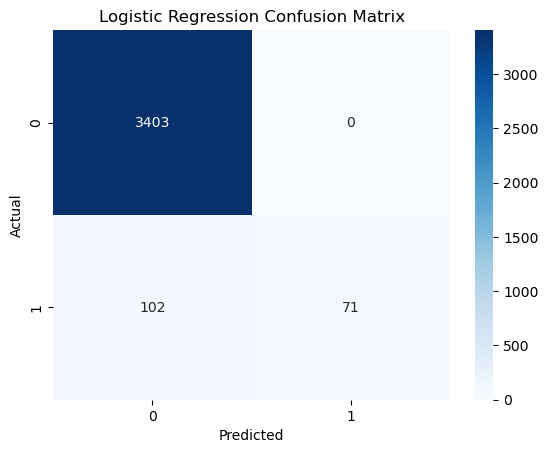

In [45]:
def plot_confusion(y_true, y_pred, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()

plot_confusion(y_test, y_pred_lr, title="Logistic Regression Confusion Matrix")

#### Predictions and Probabilities

In [47]:
# Predict on the test set
y_pred = lr_model.predict(X_test)

# Get prediction probabilities for the positive class (fraudulent=1)
y_prob = lr_model.predict_proba(X_test)[:, 1]

# First, get the original test rows
X_test_indices = X_test.nonzero()[0]  # optional if X_test is sparse
test_df = df.iloc[y_test.index]  # ensure you align indices

# Create the results table
results_df = test_df[['job_id', 'title', 'description', 'fraudulent']].copy()
results_df['predicted_fraudulent'] = y_pred
results_df['fraud_probability'] = y_prob

# Show top rows
results_df.head(10)

,job_id,title,description,fraudulent,predicted_fraudulent,fraud_probability
16995,16996,EXCELLENT ER RN Opportunity Available Now,"Our client, located in Urban, IL, is looking f...",0,0,0.048451
9357,9358,Scrum Master / Website Development Project Man...,Other agencies may call this job “Project Mana...,0,0,0.004131
11561,11562,HR Assistant - Contract,Squiz is an Australian owned and now multinati...,0,0,0.010968
1105,1106,Regional Sales Director South Africa,The Regional Sales Director SA will help deriv...,0,0,0.006012
1980,1981,Petrophysicist,About the CompanyThis is an amazing job opport...,0,0,0.017141
17264,17265,Front-End Developer/HTML/JavaScript/CSS,"Our Company, Replise, a growing and exciting s...",0,0,0.003651
13052,13053,Software Engineer,We are seeking a bright and capable Senior or ...,0,0,0.010174
5549,5550,Customer Service Rep - CoMed Energy Choice Pro...,NY Marketing Firm is currently hiring entry le...,0,0,0.012934
9399,9400,Web ASP.NET/C# Developer (Remote),"We are actively seeking a new [A] agent, team ...",0,0,0.004872
9333,9334,ANDROID DEVELOPER,Requirements:Candidate must possess at least a...,0,0,0.014959


In [48]:
wrong_preds = results_df[results_df['fraudulent'] != results_df['predicted_fraudulent']]
print(f"Number of wrong predictions: {len(wrong_preds)}")
wrong_preds.head(10)

Number of wrong predictions: 102


,job_id,title,description,fraudulent,predicted_fraudulent,fraud_probability
7830,7831,Position Finance Assistant,"We have positions available for confident, out...",1,0,0.383305
7344,7345,Senior System Engineering Manager,"Senior System Engineering Manager San Jose, CA...",1,0,0.203872
8836,8837,Maintenance Specialist,ResponsibilitiesResponsibilities:Responsibilit...,1,0,0.129084
7131,7132,Health + Environmental Professional,Health &amp; Environmental Professional Bakers...,1,0,0.246972
17648,17649,Vemma Brand Partner,Looking for motivated and hard working individ...,1,0,0.052924
17604,17605,Subsea Installation Engineer,Job Description: Candidate should have a stron...,1,0,0.345580
12104,12105,Production Manager Heavy Duty Diesel 2022,2022Job Title: Production Manager Heavy Duty D...,1,0,0.457683
17655,17656,"Controls Engineer - Troy, MI",Title: Controls EngineerDuration: Long term co...,1,0,0.032085
17549,17550,Sales manager,Collaborates with [Insert title] in establishi...,1,0,0.069514
7177,7178,Fraud Detection Analyst,POSITION : Fraud Detection AnalystCustomer fac...,1,0,0.125612


#### Models Limitations 

There are several factors for the wrong predictions but possibly:
* Naive Bayes assumes feature independence, which isn’t true for natural language.

* Logistic Regression is linear and may not capture complex patterns.

Some fake posts may be very similar to real ones—simple models can’t perfectly separate them.     